In [ ]:
# @title Importing dependencies
import numpy
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [ ]:
# @title Downloading MNIST dataset
mnist_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))
mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.15MB/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
# @title Binarise MNIST data
def binarise_mnist(mnist):
    mnist_bin = []
    for img, label in mnist:
        mnist_bin.append((torch.where(img < 0.5, 0.0, 1.0), label))
    return mnist_bin

In [ ]:
X_train = binarise_mnist(mnist_train)
X_test = binarise_mnist(mnist_test)

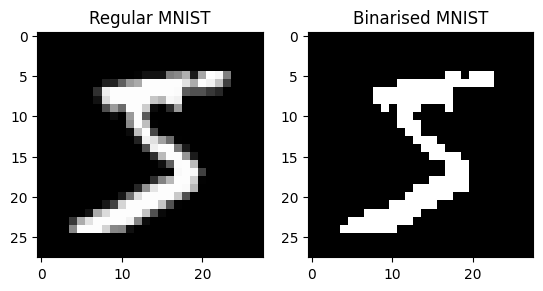

In [ ]:
# @title Visualise MNIST and binarised MNIST
import matplotlib.pyplot as plt

# Get an example image and label from mnist_train
img, label = mnist_train[0]

# Get the corresponding binarised image and label from X_train
binarised_img, binarised_label = X_train[0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Plot the regular MNIST image on the first subplot
axes[0].imshow(img.squeeze(), cmap='gray')
axes[0].set_title('Regular MNIST')

# Plot the binarised MNIST image on the second subplot
axes[1].imshow(binarised_img.squeeze(), cmap='gray')
axes[1].set_title('Binarised MNIST')

# Show the plot
plt.show()

### Defining Classes for Model Architecture

In [ ]:
class MaskedConvolution2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type):
        super(MaskedConvolution2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.mask_type = mask_type
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size)
        self.create_mask()

    def create_mask(self):
        mask = torch.ones(self.kernel_size, self.kernel_size)
        mask[self.kernel_size // 2, self.kernel_size // 2:] = 0
        mask[self.kernel_size // 2 + 1:, :] = 0
        if self.mask_type == 'B':
            mask[self.kernel_size // 2, self.kernel_size // 2] = 1
        self.register_buffer('mask', mask)

    def forward(self, X):
        self.conv.weight.data = self.conv.weight.data * self.mask
        return self.conv(X)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_channels):
        super(ResidualBlock, self).__init__()
        self.hidden_channels = hidden_channels
        self.maskedconv1 = MaskedConvolution2D(2 * self.hidden_channels, self.hidden_channels, 1, 'A')
        self.maskedconv2 = MaskedConvolution2D(self.hidden_channels, self.hidden_channels, 3, 'B')
        self.maskedconv3 = MaskedConvolution2D(self.hidden_channels, 2 * self.hidden_channels, 1, 'B')
        self.relu = nn.ReLU()
        self.padding = nn.ZeroPad2d(1)

    def forward(self, X):
        out = self.maskedconv1(X)
        out = self.relu(out)
        out = self.padding(out)
        out = self.maskedconv2(out)
        out = self.relu(out)
        out = self.maskedconv3(out)
        out += X
        return out

In [ ]:
class PixelCNN(nn.Module):
    def __init__(self, hidden_channels, out_hidden_channels, residual_blocks):
        super(PixelCNN, self).__init__()
        self.hidden_channels = hidden_channels
        self.out_hidden_channels = out_hidden_channels
        self.residual_blocks = residual_blocks

        layers = []
        layers.append(nn.ZeroPad2d(4))
        layers.append(MaskedConvolution2D(1, 2 * self.hidden_channels, 7, 'A'))
        for _ in range(residual_blocks):
            layers.append(ResidualBlock(self.hidden_channels))
        layers.append(MaskedConvolution2D(2 * self.hidden_channels, 2 * self.out_hidden_channels, 3, 'B'))
        layers.append(nn.ReLU())
        layers.append(MaskedConvolution2D(2 * self.out_hidden_channels, self.out_hidden_channels, 1, 'B'))
        layers.append(nn.ReLU())
        layers.append(MaskedConvolution2D(self.out_hidden_channels, 1, 1, 'B'))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

### Visualise Forward Pass

In [ ]:
model = PixelCNN(hidden_channels=128, out_hidden_channels=128, residual_blocks=15)
img, label = X_train[0]
y = model(img)
img.shape, y.shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

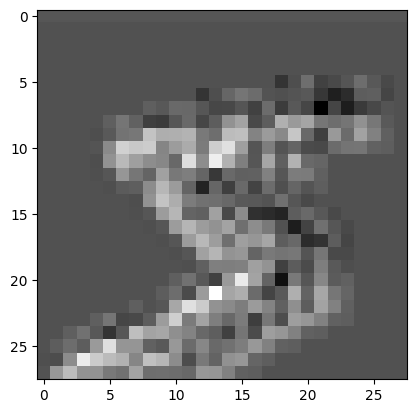

In [ ]:
# Plot y
plt.imshow(y.squeeze().detach().numpy(), cmap='gray')
plt.show()

### Train Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# @title Creating DataLoader for binarised MNIST
from torch.utils.data import DataLoader

train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
test_loader = DataLoader(X_test, batch_size=32, shuffle=False)

In [ ]:
# @title Training loop
torch.manual_seed(42)
epochs = 50

model = PixelCNN(hidden_channels=128, out_hidden_channels=128, residual_blocks=15)
criterion = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.5)
model.to(device)

model.train()
for epoch in range(epochs):
    loss = 0
    for img, _ in train_loader:
        img = img.to(device)

        optimiser.zero_grad()
        y = model(img)
        batch_loss = criterion(y, img)
        loss += batch_loss
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimiser.step()
    scheduler.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item() / len(train_loader)}")

Epoch: 5, Loss: 0.09312305501302083
Epoch: 10, Loss: 0.09252236328125
Epoch: 15, Loss: 0.09201869303385417
Epoch: 20, Loss: 0.09188890787760416
Epoch: 25, Loss: 0.09162998046875
Epoch: 30, Loss: 0.0915806884765625
Epoch: 35, Loss: 0.09143722330729166
Epoch: 40, Loss: 0.09141708984375
Epoch: 45, Loss: 0.09134077962239584
Epoch: 50, Loss: 0.09132937825520833


## Results
### Run 1:
- Epochs: 50
- Optimiser: RMSprop
- Hidden channels: 16
- Output hidden channels: 32
- Residual blocks: 5
- Learning rate: 0.01
- **Final Loss: 0.09763512369791667**

### Run 2:
- Used my original masking
- Epochs: 20
- Optimiser: RMSprop
- Hidden channels: 16
- Output hidden channels: 32
- Residual blocks: 5
- Learning rate: 0.01
- **Final Loss: 0.0967809814453125**

### Run 3:
- Used my original masking, scheduler, and clip_grad_norm
- Epochs: 50
- Optimiser: Adam
- Hidden channels: 128
- Output hidden channels: 128
- Residual blocks: 5
- Learning rate: 0.0001
- **Training time: 3913.674 s**
- **Final Loss: 0.09625528157552084**

### Run 4:
- Epochs: 50
- Optimiser: Adam
- Hidden channels: 128
- Output hidden channels: 128
- Residual blocks: 15
- Learning rate: 0.001
- **Training time: 13381.178 s**
- **Final Loss: 0.09132937825520833**

In [ ]:
# @title Generate images

def generate_images(model, image_shape=(1, 28, 28), num_samples=10, device="cpu"):
    model.eval()  # Set model to evaluation mode

    samples = torch.zeros((num_samples, *image_shape), device=device)  # Start with blank images

    with torch.inference_mode():  # No need to compute gradients
        for i in range(image_shape[1]):  # Iterate over height (rows)
            for j in range(image_shape[2]):  # Iterate over width (columns)
                # Get model prediction for the current (incomplete) image
                out = model(samples)  # Forward pass through PixelCNN
                probs = out[:, :, i, j]  # Get probability for current pixel

                # Sample binary value based on predicted probability
                sampled_pixel = torch.bernoulli(probs)  # 1 with prob=probs, else 0

                # Assign the sampled value to the image
                samples[:, :, i, j] = sampled_pixel

    return samples.cpu()

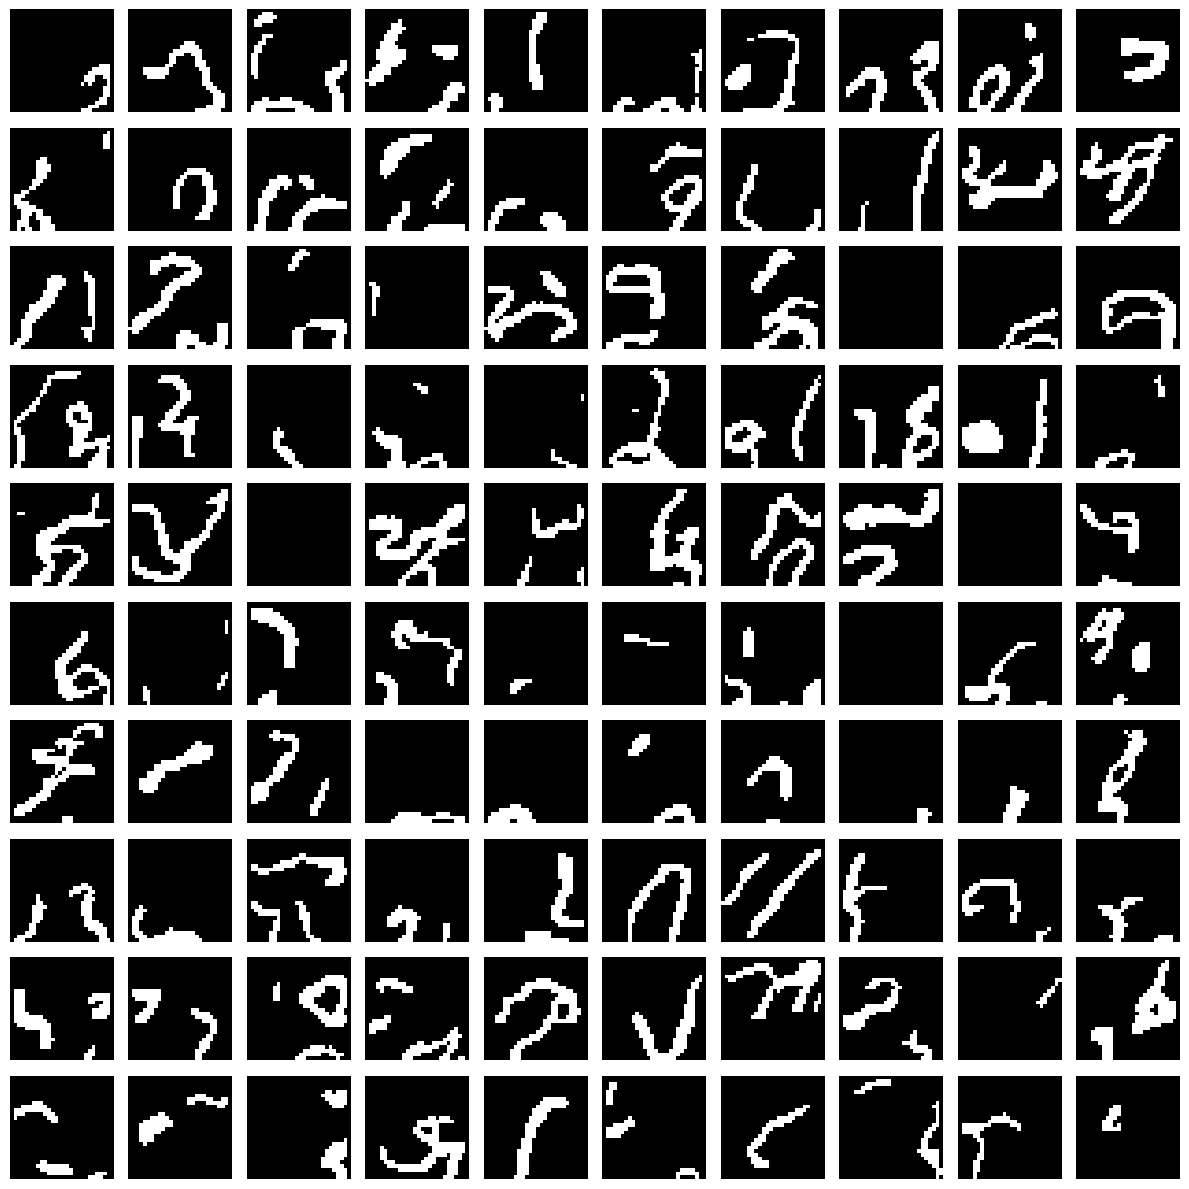

In [ ]:
generated_images = generate_images(model, num_samples=100, device=device)

# Plot the 100 images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'pixelcnn_model.pth')

torch.save(optimiser.state_dict(), 'pixelcnn_optimiser.pth')

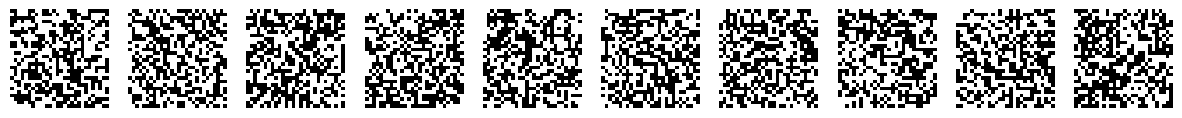

In [ ]:
untrained_model = PixelCNN(hidden_channels=16, out_hidden_channels=32, residual_blocks=5)
untrained_model.to(device)
generated_images = generate_images(untrained_model, num_samples=10, device=device)

# Plot generated images
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated_images[i].squeeze(), cmap="gray")
    axes[i].axis("off")

plt.show()

In [ ]:
# @title Calculate NLL and bits/dim metrics

model = PixelCNN(hidden_channels=128, out_hidden_channels=128, residual_blocks=15)
model.load_state_dict(torch.load('/content/pixelcnn_model.pth'))
model.to(device)

<ipython-input-12-026352a214ab>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/pixelcnn_model.pth'))


PixelCNN(
  (net): Sequential(
    (0): ZeroPad2d((4, 4, 4, 4))
    (1): MaskedConvolution2D(
      (conv): Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1))
    )
    (2): ResidualBlock(
      (maskedconv1): MaskedConvolution2D(
        (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (maskedconv2): MaskedConvolution2D(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (maskedconv3): MaskedConvolution2D(
        (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (relu): ReLU()
      (padding): ZeroPad2d((1, 1, 1, 1))
    )
    (3): ResidualBlock(
      (maskedconv1): MaskedConvolution2D(
        (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (maskedconv2): MaskedConvolution2D(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (maskedconv3): MaskedConvolution2D(
        (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (relu)

In [ ]:
import math
import torch
import torch.nn as nn

def compute_bits_per_dim(model, data_loader, device):
    """
    Computes the average bits per dimension (bits/dim) for a given model and dataset.
    This function uses binary cross-entropy as the negative log likelihood (in nats)
    and converts it to bits by dividing by log(2).
    """
    criterion = nn.BCELoss(reduction='sum')
    model.eval()
    total_loss = 0.0
    total_elements = 0
    with torch.inference_mode():
        for imgs, _ in data_loader:
            imgs = imgs.to(device)
            batch_size = imgs.shape[0]
            # For MNIST, each image is 28x28 so number of pixels per sample:
            num_pixels = imgs.shape[2] * imgs.shape[3]
            output = model(imgs)
            # Compute the BCE loss (sum over all pixels)
            loss = criterion(output, imgs)
            total_loss += loss.item()
            total_elements += batch_size * num_pixels

    # Average negative log-likelihood (in nats per pixel)
    average_nll = total_loss / total_elements
    # Convert nats to bits (1 nat = 1/log(2) bits)
    bits_per_dim = average_nll / math.log(2)
    return average_nll, bits_per_dim

average_nll, bits_dim = compute_bits_per_dim(model, test_loader, device)
print(f"Average NLL (nats per pixel): {average_nll}")
print(f"Bits per dim: {bits_dim}")

Average NLL (nats per pixel): 0.09190635352621274
Bits per dim: 0.132592840458455


In [ ]:
# @title Finding NLL and bits/dim metrics for train data

average_nll, bits_dim = compute_bits_per_dim(model, train_loader, device)
print(f"Average NLL (nats per pixel): {average_nll}")
print(f"Bits per dim: {bits_dim}")

Average NLL (nats per pixel): 0.09129009278485564
Bits per dim: 0.13170376414300458
